In [1]:
ROOT_PATH = '../../../../'
# UKBB_DATA_PATH = ROOT_PATH + 'assets/data/ukbb/'
BASE_LOG_PATH = ROOT_PATH + 'medical_mesh_experiments/SVIExperiment'
# FIGURE_SAVE_PATH = 'figures'

In [2]:
import sys
import os

sys.path.append(ROOT_PATH)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
%matplotlib inline
import inspect
from collections import OrderedDict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import torch
import seaborn as sns

torch.autograd.set_grad_enabled(False);

# import os
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

# import panel as pn
# pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

# from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

In [4]:
# from coma.datasets.ukbb_meshdata import UKBBMeshDataset, VerticesDataLoader
# from coma.utils import transforms

# # Preprocessor
# preprocessor = transforms.get_transforms()

# brain_substructure = 'BrStem'

# # Load Dataset
# mesh_path = "/vol/biomedic3/bglocker/brainshapes"
# cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
# csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
# split = 0.8

# substructure_to_udi = {
#     'BrStem': '25025-2.0', 
#     'L_Thal': '25011-2.0',
#     'L_Caud': '25013-2.0',
#     'L_Puta': '25015-2.0',
#     'L_Pall': '25017-2.0',
#     'L_Hipp': '25019-2.0',
#     'L_Amyg': '25021-2.0',
#     'L_Accu': '25023-2.0',
#     'R_Thal': '25012-2.0',
#     'R_Caud': '25014-2.0',
#     'R_Puta': '25016-2.0',
#     'R_Pall': '25018-2.0',
#     'R_Hipp': '25020-2.0',
#     'R_Amyg': '25022-2.0',
#     'R_Accu': '25024-2.0',
# }

# feature_name_map = {
#     '31-0.0': 'sex',
#     '21003-0.0': 'age',
#     substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
#     '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
# }

# metadata_df = pd.read_csv(csv_path)

# total_train_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=True,
#     transform=preprocessor,
#     reload_path=False,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )

# val_split = 0.1
# total_train_length = len(total_train_dataset)
# val_length = int(val_split * total_train_length)
# train_length = total_train_length - val_length

# train_dataset, val_dataset = torch.utils.data.random_split(
#     total_train_dataset,
#     lengths=[train_length, val_length],
#     generator=torch.Generator().manual_seed(42),
# )

# data = [train_dataset[i] for i in range(len(train_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# # metadata_df.head()
# torch.save(meshes, 'training_hipp_meshes.pt')
# metadata_df.to_csv('training_hipp_metadata.csv')

# print(preprocessor.transforms[-2].reg.fixed_image)

# metadata_df = pd.read_csv(csv_path)
# total_test_dataset = UKBBMeshDataset(
#     mesh_path,
#     substructures=[brain_substructure],
#     split=split,
#     train=False,
#     transform=preprocessor,
#     reload_path=True,
#     features_df=metadata_df,
#     feature_name_map=feature_name_map,
#     cache_path=cache_path,
# )
# data = [total_test_dataset[i] for i in range(len(total_test_dataset))]
# meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
# print(meshes.shape)
# print(preprocessor.transforms[-2].reg.fixed_image)
# metadata_df = pd.concat([df for (_, df) in data], 0)
# print(metadata_df.shape)
# metadata_df.head()
# torch.save(meshes, 'testing_hipp_meshes.pt')
# metadata_df.to_csv('testing_hipp_metadata.csv')

In [5]:
test_stem_meshes = torch.tensor(torch.load('testing_meshes.pt'))
test_stem_metadata_df = pd.read_csv('testing_metadata.csv')
print(test_stem_metadata_df.head())

train_stem_metadata_df = pd.read_csv('training_metadata.csv')
train_stem_meshes = torch.tensor(torch.load('training_meshes.pt'))
print(train_stem_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58             23486       1073400
1        3178  5027256    1   60             25223       1282190
2        4669  5027577    0   65             24819       1097400
3         845  5027876    0   56             21884       1093200
4        4457  5028604    1   62             24066       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220


In [6]:
test_hipp_meshes = torch.tensor(torch.load('testing_hipp_meshes.pt'))
test_hipp_metadata_df = pd.read_csv('testing_hipp_metadata.csv')
print(test_hipp_metadata_df.head())

train_hipp_metadata_df = pd.read_csv('training_hipp_metadata.csv')
train_hipp_meshes = torch.tensor(torch.load('training_hipp_meshes.pt'))
print(train_hipp_metadata_df.head())

   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        4804  5026976    0   58             23486       1073400
1        3178  5027256    1   60             25223       1282190
2        4669  5027577    0   65             24819       1097400
3         845  5027876    0   56             21884       1093200
4        4457  5028604    1   62             24066       1191110
   Unnamed: 0      eid  sex  age  structure_volume  brain_volume
0        8809  3820915    0   56             23764       1041180
1       11675  3677460    1   66             22000       1143400
2        9633  4383421    1   63             27148       1369520
3        8374  3069151    0   59             20223        980627
4       14213  1457636    0   50             21183       1386220


In [7]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976'
stem_name = 'T1_first-BrStem_first.vtk'
hipp_name = 'T1_first-R_Hipp_first.vtk'
stem_template = pv.read(f'{template_path}/{stem_name}')
hipp_template = pv.read(f'{template_path}/{hipp_name}')

In [8]:
# _df = pd.read_csv(csv_path)
# base_dir_shapes = '/vol/biomedic3/bglocker/brainshapes/'
# min_x = float('-inf')
# for x in os.listdir(base_dir_shapes):
#     mesh = pv.read(f'{base_dir_shapes}/{x}/{stem_name}')
#     row = _df[_df.eid == int(x)][feature_name_map].rename(columns=feature_name_map)
#     batch = prep_batch(np.expand_dims(np.array(mesh.points), 0), row, 0, 1)
#     loss = brainstem_exps[99].svi.evaluate_loss(**batch)
#     metrics = brainstem_exps[99].get_trace_metrics(batch)
#     if metrics['log p(x)'] > min_x:
#         print(x, metrics['log p(x)'])
#         min_x = metrics['log p(x)']

## Load Model 

In [9]:
from deepscm.experiments.medical_meshes import ukbb  # noqa: F401
from deepscm.experiments.medical_meshes.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [10]:
import argparse

def load_model(base_log_path, exp='ConditionalVISEM', version='version_87', gpu=False):
    checkpoint_path = f'{base_log_path}/{exp}/{version}/'
    base_path = os.path.join(checkpoint_path, 'checkpoints')
    checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])
    
    # device = 'cuda' if gpu else 'cpu'
    ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    hparams = ckpt['hyper_parameters']
    hparams['gpu'] = 1 if gpu else 0
    # print(hparams)

    model_class = MODEL_REGISTRY[hparams['model']]

    model_params = {
        k: v for k, v in hparams.items() if (
            k in inspect.signature(model_class.__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
            or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters
        )
    }
    model_params['gpu'] = 1 if gpu else 0
    # print(model_params)

    new_state_dict = OrderedDict()

    for key, value in ckpt['state_dict'].items():
        new_key = key.replace('pyro_model.', '')
        new_state_dict[new_key] = value
    
    loaded_model = model_class(**model_params)
    loaded_model.load_state_dict(new_state_dict)

    for p in loaded_model._buffers.keys():
        if 'norm' in p:
            setattr(loaded_model, p, getattr(loaded_model, p))

    loaded_model.eval()

    def sample_pgm(num_samples, model):
        with pyro.plate('observations', num_samples):
            return model.pgm_model()

    model = partial(sample_pgm, model=loaded_model)
    
    hparams = argparse.Namespace(**hparams)
    exp_class = EXPERIMENT_REGISTRY['SVIExperiment']
    experiment = exp_class.load_from_checkpoint(
        checkpoint_path, pyro_model=loaded_model, hparams=hparams
    )
    
    return loaded_model, model, experiment

In [11]:
# _model = load_model(BASE_LOG_PATH, gpu=False)

In [12]:
exp = 'ConditionalVISEM'

brainstem_model_nos = [113, 115, 116, 117]
brainstem_models_and_exp = [
    load_model(BASE_LOG_PATH, exp, f'version_{no}')
    for no in brainstem_model_nos
]

hipp_model_nos = [90, 94, 97, 101]
hipp_models_and_exp = [
    load_model(BASE_LOG_PATH, exp, f'version_{no}')
    for no in hipp_model_nos
]

def get_models_as_dict(model_nos, model_and_exp, idx):
    return {
        model_nos[i]: brainstem_models_and_exp[i][idx]
        for i in range(len(model_nos))
    }

brainstem_loaded_models = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 0)
brainstem_models = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 1)
brainstem_exps = get_models_as_dict(brainstem_model_nos, brainstem_models_and_exp, 2)

hipp_loaded_models = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 0)
hipp_models = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 1)
hipp_exps = get_models_as_dict(hipp_model_nos, hipp_models_and_exp, 2)

(642, 3)
++++++++++++++++ cpu
(642, 3)
++++++++++++++++ cpu
(642, 3)
++++++++++++++++ cpu
(642, 3)
++++++++++++++++ cpu
(664, 3)
++++++++++++++++ cpu
(664, 3)
++++++++++++++++ cpu
(664, 3)
++++++++++++++++ cpu
(664, 3)
++++++++++++++++ cpu


In [131]:
from scipy.stats import gaussian_kde

def plot_joint_pdf(x, y, logp, ax=None):
    if ax is None:
        ax = plt.gca()
    prob = logp.exp().numpy().T
    mi = prob.min()
    ma = np.percentile(prob.flat, 99.5)
    step = (ma - mi) / 5
    levels = np.arange(mi, ma, step) + step
    ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, antialiased=True, extend='max')
    
age_range = torch.arange(38, 73, 0.1, dtype=torch.float)
bvol_range = torch.arange(8.5e5, 15.5e5, 5e3, dtype=torch.float)
vvol_range = torch.arange(0, 1.5e5, 1e3, dtype=torch.float)

age_range_, bvol_range_ = [x.reshape(-1, 1) for x in torch.meshgrid(age_range, bvol_range)]

prob_maps = {'model': {}}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    with torch.no_grad():
        trace = pyro.poutine.trace(pyro.condition(brainstem_models[116], data=cond_data)).get_trace(age_range_.shape[0])
        trace.compute_log_prob()

    log_prob = trace.nodes['age']['log_prob'] + trace.nodes['brain_volume']['log_prob']
    prob_maps['model'][f"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'brain_volume': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(age_range.shape[0], bvol_range.shape[0])
    }

prob_maps['true'] = {}
for sex in [0, 1]:
    cond_data = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'sex': torch.tensor(float(sex)).expand(age_range_.shape)
    }

    sel = test_stem_metadata_df['sex'] == sex
    data = np.stack([
        test_stem_metadata_df['age'][sel].values,
        test_stem_metadata_df['brain_volume'][sel].values], -1)
    print(data.shape)
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([age_range_.flatten(), bvol_range_.flatten()], 0)))
    prob_maps['true'][rf"$s=\mathrm{{{['female', 'male'][sex]}}}$"] = {
        'age': age_range_,
        'brain_volume': bvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], bvol_range.shape[0]))
    }

(1529, 2)
(1372, 2)


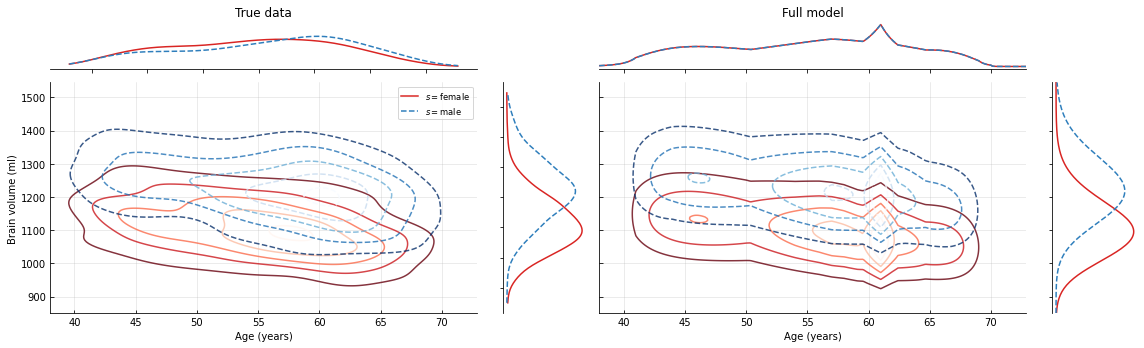

In [160]:
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

def make_transparent_cmap(cmap):
    n = 256
    colours = cmap(np.linspace(0, 1, n))
    colours[:, -1] = np.linspace(0, 1, n)
    return ListedColormap(colours)    

def plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y):
    contours = []
    for j, (k, v) in enumerate(prob_maps[exp].items()):
        shape = (age_range.shape[0], bvol_range.shape[0])
        age = v['age'].reshape(shape).numpy()
        bvol = v['brain_volume'].reshape(shape).numpy() / 1000
        log_prob = v['log_prob'].reshape(shape).numpy()
        prob = np.exp(log_prob)
        prob /= prob.sum()

        da = age[1, 0] - age[0, 0]
        db = bvol[0, 1] - bvol[0, 0]
        marg_a = prob.sum(1) * da
        marg_b = prob.sum(0) * db  * 1000

        mi = prob.min()
        ma = np.percentile(prob.flat, 99.5)
        step = (ma - mi) / 5
        levels = np.arange(mi, ma, step) + step

        filled = False # j == 0
        dashed = j == 1
        cmap = cmaps[j]
        colour = cmap(.7)

        alpha = .8
        # print(bvol, marg_b)
        if filled:
            ax_joint.contourf(age, bvol, prob, cmap=cmap, antialiased=True, levels=levels, alpha=alpha, extend='max')
            c = ax_marg_x.fill_between(age[:, 0], marg_a, color=colour, lw=0, alpha=alpha)
            ax_marg_y.fill_betweenx(bvol[0, :], marg_b, color=colour, lw=0, alpha=alpha)
        else:
            kwargs = dict(cmap=cmap.reversed(), antialiased=True, levels=levels, alpha=alpha)
            if dashed:
                kwargs['linestyles'] = 'dashed'
            c = ax_joint.contour(age, bvol, prob, **kwargs)

        kwargs = dict(ls='--') if dashed else {}
        h, = ax_marg_x.plot(age[:, 0], marg_a, c=colour, **kwargs)
        ax_marg_y.plot(marg_b, bvol[0, :], c=colour, **kwargs)

        if filled:
            contours.append(c)
        else:
            contours.append(h)

    ax_marg_x.set_title(titles[exp])
    ax_joint.set_xlabel('Age (years)', fontsize='medium')
    ax_joint.tick_params(axis='y', direction='in')
    ax_joint.tick_params(axis='x', direction='in')
    if i == 0:
        ax_joint.set_ylabel('Brain volume (ml)', fontsize='medium')
        ax_joint.legend(contours, prob_maps[exp].keys(), fontsize='small')

def plot_all_joints():
    n_exp = len(titles)
    width = 16
    height = width / (1.618 * 2)
    fig = plt.figure(figsize=(width, height))
    ratio = 5
    global_gs = fig.add_gridspec(1, n_exp)
    
    ax_joint0 = ax_marg_x0 = ax_marg_y0 = None

    margin = 0.02 / n_exp
    width = 1. / n_exp
    for i, exp in enumerate(titles.keys()):
        gs = global_gs[i].subgridspec(2, 2, width_ratios=[ratio, 1], height_ratios=[1, ratio],
                                   wspace=0.1, hspace=0.1)

        ax_joint = fig.add_subplot(gs[1, 0], sharex=ax_joint0, sharey=ax_joint0)
        ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint0, sharey=ax_marg_x0)
        ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint0, sharex=ax_marg_y0)
        if i == 0:
            ax_joint0 = ax_joint
            ax_marg_x0 = ax_marg_x
            ax_marg_y0 = ax_marg_y
        
        plt.setp(ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(ax_marg_y.get_yticklabels(), visible=False)
        
        # Turn off the ticks on the density axis for the marginal plots
        plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax_marg_x.get_yticklabels(), visible=False)
        plt.setp(ax_marg_y.get_xticklabels(), visible=False)
        for s in ['top', 'right']:
            ax_joint.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax_marg_x.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax_marg_y.spines[s].set_visible(False)
        ax_marg_x.yaxis.grid(False)
        ax_marg_y.xaxis.grid(False)
        
        if i > 0:
            plt.setp(ax_joint.get_yticklabels(), visible=False)
            
        ax_joint.grid('on', lw=.5, alpha=.5)

        plot_exp(i, exp, ax_joint, ax_marg_x, ax_marg_y)
    
    fig.tight_layout()

titles = {'true': 'True data', 'model': 'Full model'}
plot_all_joints()
plt.savefig(f'./medical_age_bvol.pdf', bbox_inches='tight')

In [114]:
age_range = torch.arange(35, 75, 0.2, dtype=torch.float)
bvol_range = torch.arange(8e5, 17e5, 5e3, dtype=torch.float)
vvol_range = torch.arange(1.3e4, 3.7e4, 5e2, dtype=torch.float)[:-1]

age_range_, vvol_range_, bvol_range_ = torch.meshgrid(age_range, vvol_range, bvol_range)

bvol_bounds = [(8e5, 10e5), (10e5, 12e5), (12e5, 14e5), (14e5, 16e5)]

prob_maps = {'model': {}}
for (bvol_lo, bvol_hi) in bvol_bounds:
    sel = (bvol_range >= bvol_lo) & (bvol_range < bvol_hi)
    cond_data = {
        'age': age_range_[:, :, sel].view(-1, 1),
        'structure_volume': vvol_range_[:, :, sel].view(-1, 1),
        'brain_volume': bvol_range_[:, :, sel].view(-1, 1),
    }

    log_probs = []
    for sex in [0, 1]:
        cond_data['sex'] = torch.full_like(cond_data['age'], float(sex))

        with torch.no_grad():
            condition = pyro.condition(brainstem_models[116], data=cond_data)
            trace = pyro.poutine.trace(condition).get_trace(cond_data['age'].shape[0])
            trace.compute_log_prob()

        log_probs.append(trace.nodes['age']['log_prob'] + trace.nodes['structure_volume']['log_prob'])

    sex_prob = torch.sigmoid(brainstem_loaded_models[116].sex_logits)
    log_prob = torch.log(sex_prob * log_probs[0].exp() + (1.-sex_prob) * log_probs[1].exp())
    prob_maps['model'][f"$b\in[{bvol_lo/1000:g},{bvol_hi/1000:g})$"] = {
        'age': trace.nodes['_RETURN']['value'][0],
        'ventricle_volume': trace.nodes['_RETURN']['value'][2],
        'brain_volume': trace.nodes['_RETURN']['value'][3],
        'log_prob': log_prob.reshape(age_range_[:, :, sel].shape)
    }
    
prob_maps['true'] = {}
for (bvol_lo, bvol_hi) in bvol_bounds:
    sel = (test_stem_metadata_df['brain_volume'] >= bvol_lo) & (test_stem_metadata_df['brain_volume'] < bvol_hi)
    data = np.stack([
        test_stem_metadata_df['age'][sel],
        test_stem_metadata_df['structure_volume'][sel]], -1)
    kde = gaussian_kde(data.T)
    log_prob = np.log(kde(torch.stack([x.flatten() for x in torch.meshgrid(age_range, vvol_range)], 0)))
    prob_maps['true'][f"$b\in[{bvol_lo/1000:g},{bvol_hi/1000:g})$"] = {
        'age': age_range_,
        'structure_volume': vvol_range_,
        'log_prob': torch.as_tensor(log_prob.reshape(age_range.shape[0], vvol_range.shape[0]))
    }

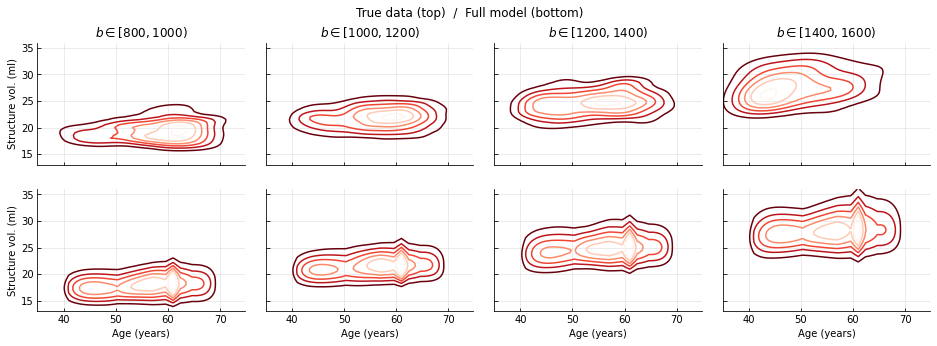

In [106]:
width = 16
height = width / (1.618 * 2)
fig, axs = plt.subplots(2, 4, figsize=(width, height), sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))

def plot_joint_pdf(x, y, logp, ax, filled=False, **kwargs):
    prob = np.exp(logp.numpy()).T

    valid = np.isfinite(prob)
    mi = prob[valid].min()
    ma = np.percentile(prob[valid].flat, 99.5)
    step = (ma - mi) / 6
    levels = np.arange(mi, ma, step) + step
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', direction='in')
    ax.tick_params(axis='x', direction='in')

    if filled:
        ax.contourf(x, y, prob, cmap=cmaps[0], levels=levels, extend='max', **kwargs)
    else:
        ax.contour(x, y, prob, cmap=cmaps[0].reversed(), levels=levels, extend='max', **kwargs)
    ax.grid('on', lw=.5, alpha=.5)

for (k, v), ax in zip(prob_maps['true'].items(), axs[0]):
    plot_joint_pdf(age_range, vvol_range / 1000, v['log_prob'], ax, filled=False)
    ax.set_title(k)
    
for (k, v), ax in zip(prob_maps['model'].items(), axs[1]):
    plot_joint_pdf(age_range, vvol_range / 1000, v['log_prob'].logsumexp(-1), ax, filled=False)

for ax in axs[1]:
    ax.set_xlabel("Age (years)", fontsize='medium')
for ax in axs[:, 0]:
    ax.set_ylabel("Structure vol. (ml)", fontsize='medium')
    
fig.suptitle("True data (top)  /  Full model (bottom)", va='top')

plt.savefig(f'./medical_age_vvol.pdf', bbox_inches='tight')